# Data editing using general fuzzy min-max neural network

This example shows how to using the general fuzzy min-max neural network (GFMMNN) to edit the training data and remove outliers. There are three different data editing approaches which are presented in [1]. This example uses a GFMMNN trained by an accelerated agglomerative learning algorithm for demonstration, but any other learning algorithms of the GFMMNN can be used within data editing functions.

[1] Gabrys, B. (2001). Data editing for neuro-fuzzy classifiers. In Proceedings of the Fourth International ICSC Symposia on Soft Computing and Intelligent Systems for Industry.

In [1]:
%matplotlib notebook

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

### Load training and testing datasets 

In [3]:
# Get the path to the this jupyter notebook file
this_notebook_dir = os.path.dirname(os.path.abspath("__file__"))
this_notebook_dir

'C:\\hyperbox-brain\\examples\\other_learning_ability_gfmm'

In [4]:
# Get the home folder of the hyperbox-brain toolbox
from pathlib import Path
project_dir = Path(this_notebook_dir).parent.parent
project_dir

WindowsPath('C:/hyperbox-brain')

In [5]:
# Create the path to the training and testing files
training_file = os.path.join(project_dir, Path("dataset/syn_num_train.csv"))
testing_file = os.path.join(project_dir, Path("dataset/syn_num_test.csv"))

In [6]:
# Create training and testing data sets
df_train = pd.read_csv(training_file, header=None)
df_test = pd.read_csv(testing_file, header=None)

Xy_train = df_train.to_numpy()
Xy_test = df_test.to_numpy()

Xtr = Xy_train[:, :-1]
ytr = Xy_train[:, -1]

Xtest = Xy_test[:, :-1]
ytest = Xy_test[:, -1]

In [7]:
from hbbrain.numerical_data.batch_learner.accel_agglo_gfmm import AccelAgglomerativeLearningGFMM

In [8]:
# Initialise a gfmm model by the accelerated agglomerative learning algorithm
theta = 0.2
gamma = 1
min_simil = 0
simil_measure = 'mid'
is_draw = False

In [9]:
import matplotlib.pyplot as plt

In [10]:
# Create a function to show input samples (in this case only two classes)
def show_2d_samples(X, y, title="Input sample"):
    colours = ['blue', 'green', 'red', 'black']
    labels = ['class 1', 'class 2', 'class 3', 'class 4']
    fig1, ax1 = plt.subplots()
    classes = np.unique(y)
    for index, c in enumerate(classes):
        data = X[y == c]  
        color = colours[index]
        label = labels[index]
        ax1.scatter(        
            data[:, 0],        
            data[:, 1],
            color=color,        
            label=label  
        )

    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.title.set_text(title)
    ax1.legend(loc='lower right')
    
    fig1.show()

### Verify the input data before doing data editing

<IPython.core.display.Javascript object>


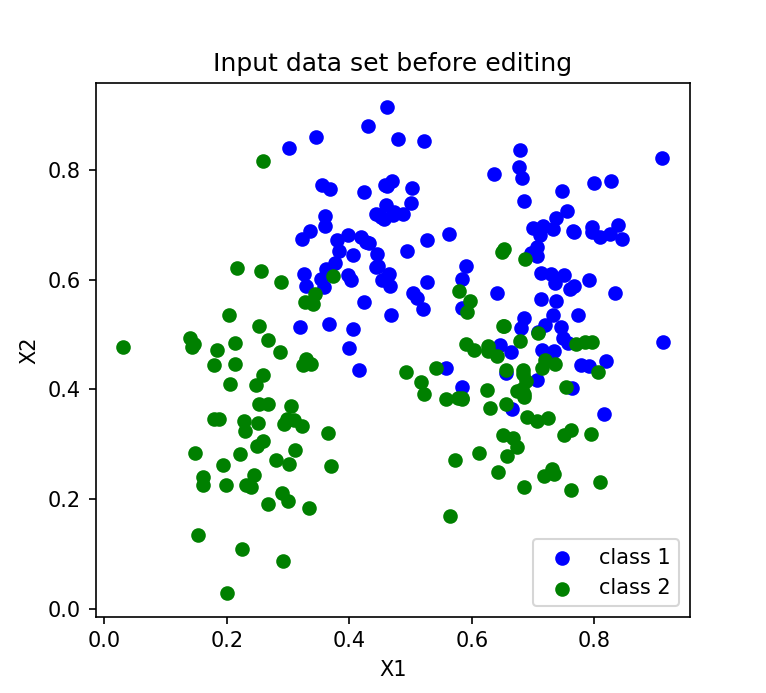

In [11]:
# Show the existing training set
show_2d_samples(Xtr, ytr, "Input data set before editing")

In [12]:
print("Number of input samples before editing = ", Xtr.shape[0])

Number of input samples before editing =  250


#### Build a GFMMNN model from the original input training data

In [13]:
agglo2_clf_original_data = AccelAgglomerativeLearningGFMM(theta=theta, gamma=gamma, min_simil=min_simil, simil_measure=simil_measure, is_draw=is_draw)

In [14]:
agglo2_clf_original_data.fit(Xtr, ytr)

AccelAgglomerativeLearningGFMM(min_simil=0, theta=0.2)

#### Display decision boundaries among classes if input data are 2-dimensional

<IPython.core.display.Javascript object>


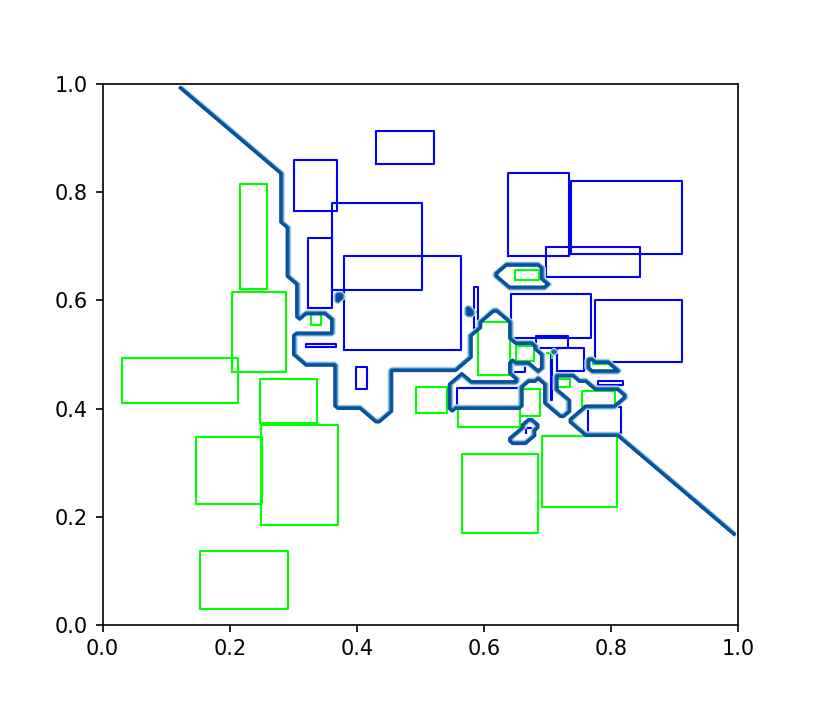

In [15]:
agglo2_clf_original_data.draw_hyperbox_and_boundary("The trained GFMM classifier and its decision boundaries")

In [16]:
print("Number of hyperboxes = ", agglo2_clf_original_data.get_n_hyperboxes())

Number of hyperboxes =  43


#### Make prediction

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
y_pred_original_data = agglo2_clf_original_data.predict(Xtest)
acc = accuracy_score(ytest, y_pred_original_data)
print(f'Accuracy = {acc * 100: .2f}%')

Accuracy =  87.00%


## 1. Method 1 of Data editing: Using k-nearest neighbors and a leave-one-out scheme.

The first of the data editing procedures examined in this paper follows the general data editing method presented in [2]. It is based on an application of the k-nearest neighbor classification rules within a leave-one-out scheme. To make it suitable for the GFMM algorithm, the membership function of the GFMMNN acts as the similarity measure utilised for finding k-nearest neighbours. In this case, the hyperboxes represent individual training data points and the outputs of the hyperbox layer nodes can be treated as the classification values. The k maximum values from the hyperbox layer outputs are used together with the above classification rules to decide whether the input is classified correctly or not.

[2] Webb, A. R. (2003). Statistical pattern recognition. John Wiley & Sons.

In [19]:
# Import the data editing function
from hbbrain.utils.data_editing import data_editing_leave_one_out

In [20]:
# Initialise a GFMMNN model using the accelerated agglomerative learning algorithm
agglo2_clf = AccelAgglomerativeLearningGFMM(theta=theta, gamma=gamma, min_simil=min_simil, simil_measure=simil_measure, is_draw=is_draw)

In [21]:
# Initialise input paramters of the data editing method
k_neighbors=5 # Using the 5-NN rule for classification
n_iters=100 # Repeat 100 times
n_last_iters=5 # If 5 consecutive iterations not remove any sample, stop the loop 
seed=0 # kernel seed for random split data

In [22]:
# Doing data editing and get the output dataset
Xtr_1, ytr_1 = data_editing_leave_one_out(Xtr, ytr, gfmm_estimator=agglo2_clf, k_neighbors=k_neighbors, n_iters=n_iters, n_last_iters=n_last_iters, seed=seed)

In [23]:
print("Number of remaining samples after editing = ", Xtr_1.shape[0])

Number of remaining samples after editing =  183


<IPython.core.display.Javascript object>


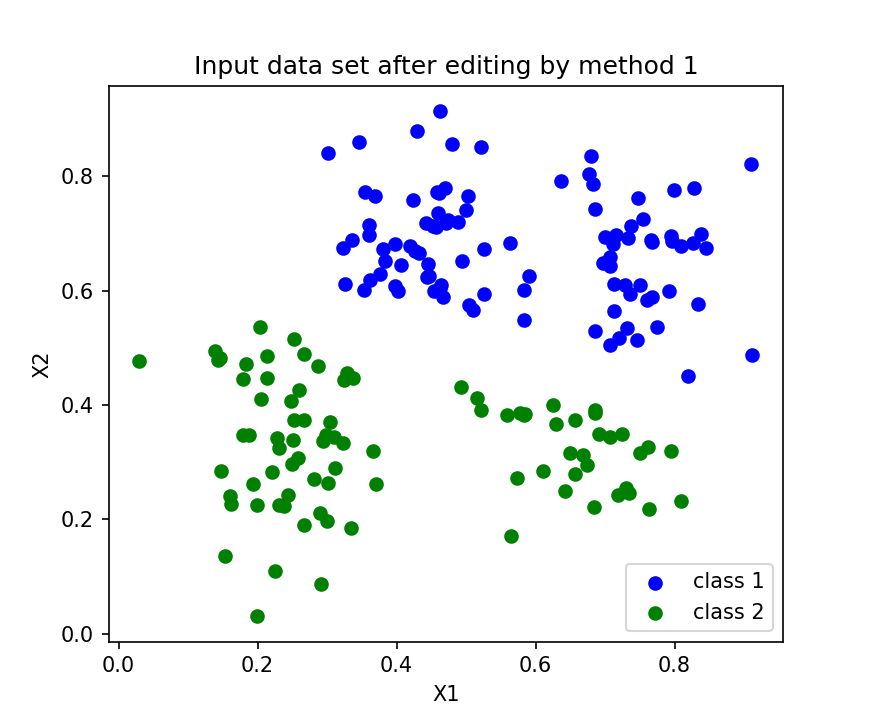

In [24]:
# Show the remaining training set
show_2d_samples(Xtr_1, ytr_1, "Input data set after editing by method 1")

#### Build a GFMMNN model from the remaining training data after editing

In [25]:
agglo2_clf_editing_method_1 = AccelAgglomerativeLearningGFMM(theta=theta, gamma=gamma, min_simil=min_simil, simil_measure=simil_measure, is_draw=is_draw)

In [26]:
agglo2_clf_editing_method_1.fit(Xtr_1, ytr_1)

AccelAgglomerativeLearningGFMM(min_simil=0, theta=0.2)

#### Display decision boundaries among classes if input data are 2-dimensional

<IPython.core.display.Javascript object>


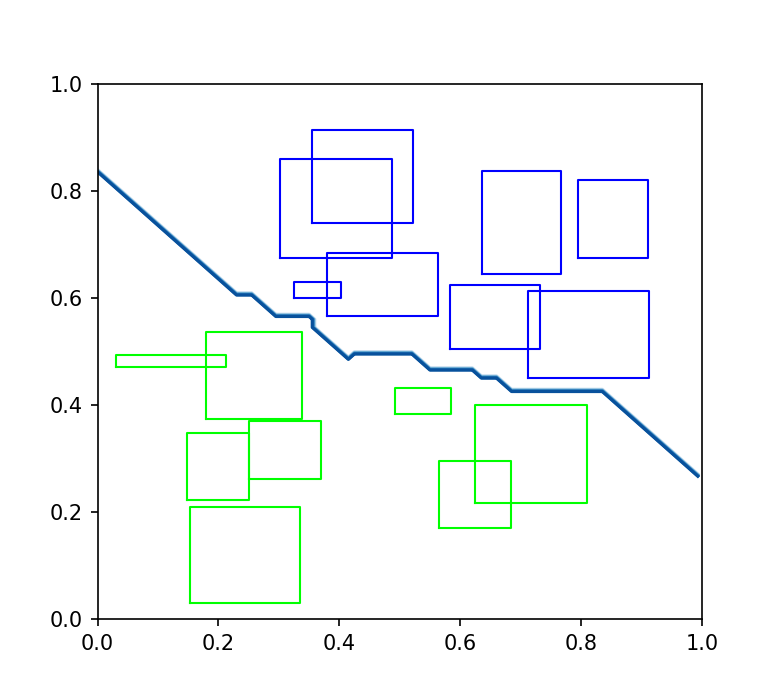

In [27]:
agglo2_clf_editing_method_1.draw_hyperbox_and_boundary("The trained GFMM classifier and its decision boundaries")

In [28]:
print("Number of hyperboxes = ", agglo2_clf_editing_method_1.get_n_hyperboxes())

Number of hyperboxes =  16


#### Make prediction

In [29]:
y_pred_editing_method_1 = agglo2_clf_editing_method_1.predict(Xtest)
acc = accuracy_score(ytest, y_pred_editing_method_1)
print(f'Accuracy = {acc * 100: .2f}%')

Accuracy =  89.60%


## 2. Method 2 of Data editing: Using repeated two fold cross-validation scheme.

The second data editing procedure is based on the repeated two-fold cross-validation. At each iteration, input data are randomly split into two separate sets. Next, a fold is used to build a GFMMNN model and the second fold is used to make prediction. This process is iterated for each fold so that each fold is used to train and validate the model in turn. After that, the misclassified samples in the validation fold are marked and the random splitting into two separate sets continues for the original training data set. The process can be repeated a fixed number of times (i.e. 100 times) or stopped if the last n iterations have not resulted in new samples being marked as misclassified. Only after the multiple cross-validation
process is completed, all the marked samples are removed and the GFMM trained for the edited training set.

In [30]:
# Import the data editing function
from hbbrain.utils.data_editing import data_editing_two_fold_cv

In [31]:
# Initialise a GFMMNN model using the accelerated agglomerative learning algorithm
agglo2_clf = AccelAgglomerativeLearningGFMM(theta=theta, gamma=gamma, min_simil=min_simil, simil_measure=simil_measure, is_draw=is_draw)

In [32]:
# Initialise input paramters of the data editing method
n_iters=100 # Repeat 100 times
n_last_iters=5 # If 5 consecutive iterations not remove any sample, stop the loop 
seed=0 # kernel seed for random split data

In [33]:
# Doing data editing and get the output dataset
Xtr_2, ytr_2 = data_editing_two_fold_cv(Xtr, ytr, gfmm_estimator=agglo2_clf, n_iters=n_iters, n_last_iters=n_last_iters, seed=seed)

In [34]:
print("Number of remaining samples after editing = ", Xtr_2.shape[0])

Number of remaining samples after editing =  133


<IPython.core.display.Javascript object>


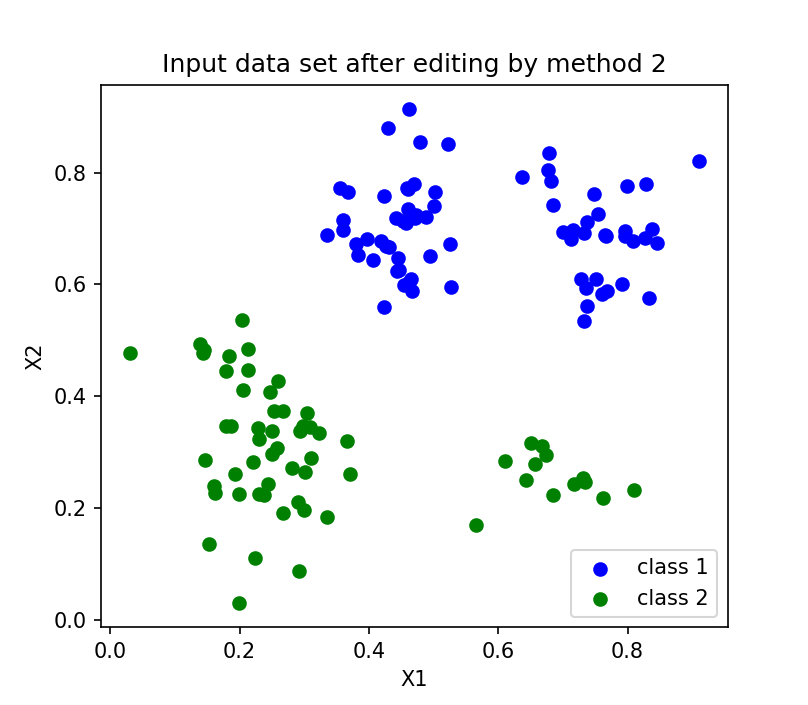

In [35]:
# Show the remaining training set
show_2d_samples(Xtr_2, ytr_2, "Input data set after editing by method 2")

#### Build a GFMMNN model from the remaining training data after editing

In [36]:
agglo2_clf_editing_method_2 = AccelAgglomerativeLearningGFMM(theta=theta, gamma=gamma, min_simil=min_simil, simil_measure=simil_measure, is_draw=is_draw)

In [37]:
agglo2_clf_editing_method_2.fit(Xtr_2, ytr_2)

AccelAgglomerativeLearningGFMM(min_simil=0, theta=0.2)

#### Display decision boundaries among classes if input data are 2-dimensional

<IPython.core.display.Javascript object>


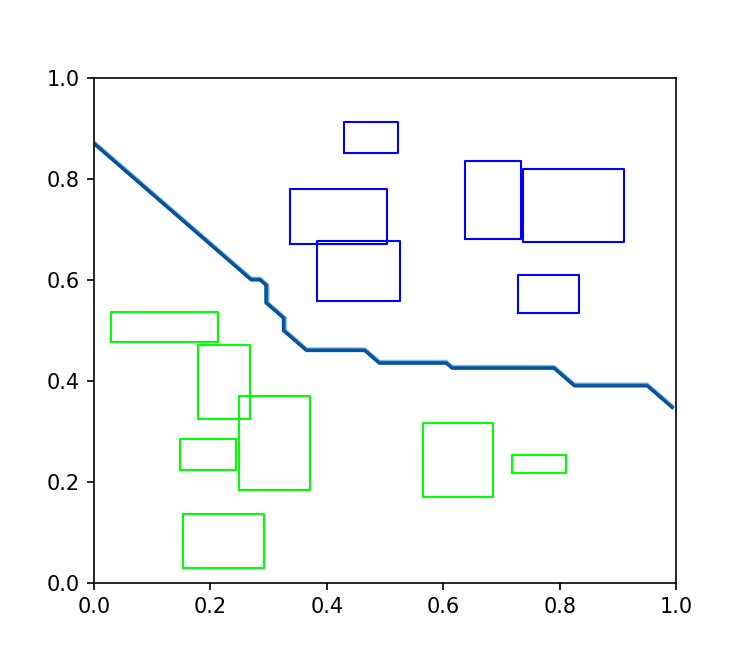

In [38]:
agglo2_clf_editing_method_2.draw_hyperbox_and_boundary("The trained GFMM classifier and its decision boundaries")

In [39]:
print("Number of hyperboxes = ", agglo2_clf_editing_method_2.get_n_hyperboxes())

Number of hyperboxes =  13


#### Make prediction

In [40]:
y_pred_editing_method_2 = agglo2_clf_editing_method_2.predict(Xtest)
acc = accuracy_score(ytest, y_pred_editing_method_2)
print(f'Accuracy = {acc * 100: .2f}%')

Accuracy =  89.80%


## 3. Method 3 of Data editing: Using repeated two fold cross-validation and a probability of misclassification for each sample.

In the second data editing method, all misclassified samples are removed. However, as it has also been indicated in the literature, removing all the misclassified samples can sometimes result in dropping whole regions of a class and essentially overediting the training set. In terms of the GFMM classifier generated for such edited data set, due to overediting, the classification models have turned out to be too simple to accurately capture the decision boundaries. Therefore, the third data editing procedure has been designed using an observation that some input data samples are more consistently used for generation of classifiers during the cross-validation process than others. It also applies to the misclassified samples, whereas some of the samples will be misclassified consistently while others only occasionally. The approach based on the rejection of all the samples which have been misclassified at least ones during the multiple cross-validation does not attempt to take this fact into
account in any way. In order to rectify this problem, an approach which will estimate the probability of every single point in the original training data set to be kept during the multiple cross-validation. This probability is simply calculated as the ratio of the number of times an input X has been retained in the validation process of the trained classifier to the total number of repetitions of the two-fold cross validation.

In [41]:
# Import the data editing function
from hbbrain.utils.data_editing import data_editing_two_fold_cv_with_probability

In [42]:
# Initialise a GFMMNN model using the accelerated agglomerative learning algorithm
agglo2_clf = AccelAgglomerativeLearningGFMM(theta=theta, gamma=gamma, min_simil=min_simil, simil_measure=simil_measure, is_draw=is_draw)

In [43]:
# Initialise input paramters of the data editing method
n_iters=100 # Repeat 100 times
min_remained_prob=0.5 # Minimum probability value so that a sample is retained (50% in this case)
seed=0 # kernel seed for random split data

In [44]:
# Doing data editing and get the output dataset
Xtr_3, ytr_3 = data_editing_two_fold_cv_with_probability(Xtr, ytr, gfmm_estimator=agglo2_clf, n_iters=n_iters, min_remained_prob=min_remained_prob, seed=seed)

In [45]:
print("Number of remaining samples after editing = ", Xtr_3.shape[0])

Number of remaining samples after editing =  217


<IPython.core.display.Javascript object>


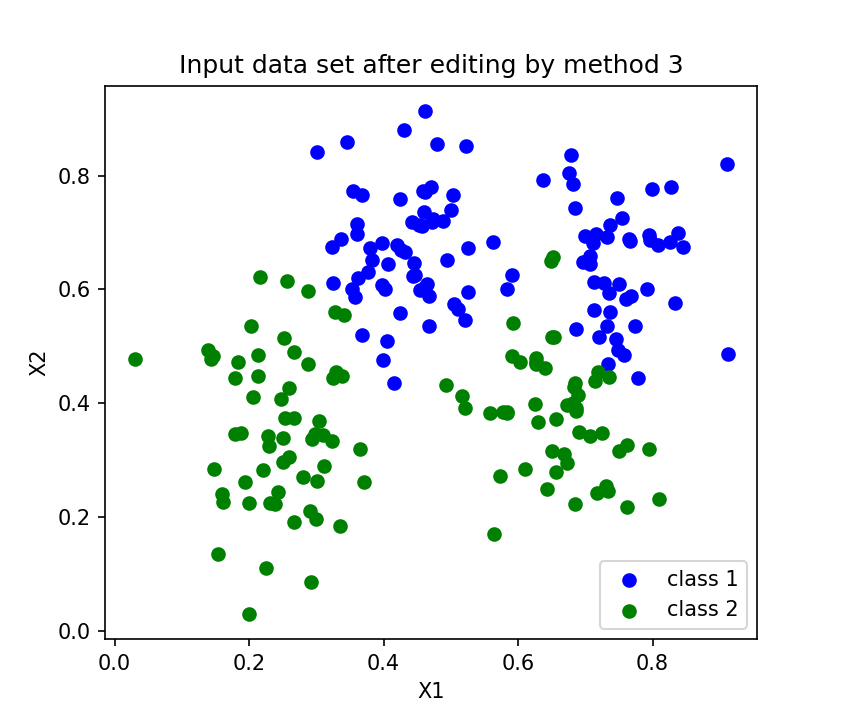

In [46]:
# Show the remaining training set
show_2d_samples(Xtr_3, ytr_3, "Input data set after editing by method 3")

#### Build a GFMMNN model from the remaining training data after editing

In [47]:
agglo2_clf_editing_method_3 = AccelAgglomerativeLearningGFMM(theta=theta, gamma=gamma, min_simil=min_simil, simil_measure=simil_measure, is_draw=is_draw)

In [48]:
agglo2_clf_editing_method_3.fit(Xtr_3, ytr_3)

AccelAgglomerativeLearningGFMM(min_simil=0, theta=0.2)

#### Display decision boundaries among classes if input data are 2-dimensional

<IPython.core.display.Javascript object>


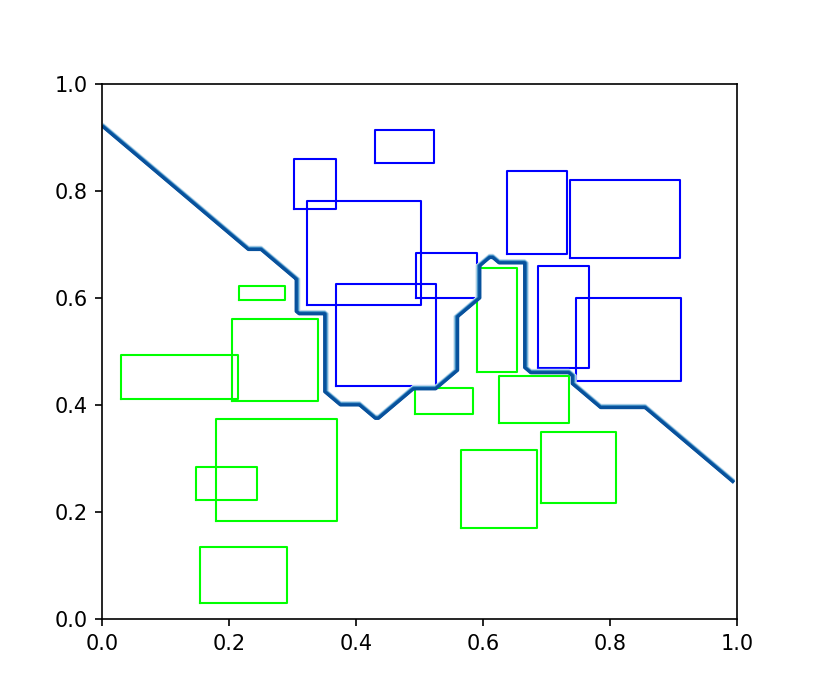

In [49]:
agglo2_clf_editing_method_3.draw_hyperbox_and_boundary("The trained GFMM classifier and its decision boundaries")

In [50]:
print("Number of hyperboxes = ", agglo2_clf_editing_method_3.get_n_hyperboxes())

Number of hyperboxes =  20


#### Make prediction

In [51]:
y_pred_editing_method_3 = agglo2_clf_editing_method_3.predict(Xtest)
acc = accuracy_score(ytest, y_pred_editing_method_3)
print(f'Accuracy = {acc * 100: .2f}%')

Accuracy =  89.60%
